# 作业2
因为我的电脑是MAC，不能使用CUDA，因此选择用colab来完成作业并提交ipynb。给老师带来麻烦啦，不好意思～

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive

drive.mount('/content/drive/')
# ipynb、model.param以及testdata_raw和train_data文件夹要放到这个路径下
path = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at /content/drive/


In [ ]:
# testdata_raw里面的是0.zip，需要解压缩
!unzip '/content/drive/MyDrive/Colab Notebooks/testdata_raw/0.zip' -d '/content/drive/MyDrive/Colab Notebooks/testdata_raw'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95000.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95001.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95002.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95003.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95004.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95005.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95006.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95007.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95008.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95009.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95010.bmp  
  inflating: /content/drive/MyDrive/Colab Notebooks/testdata_raw/0/95011.bmp  
  inflating: /content/dri

## 一、数据处理
因为source data(训练集)是照片，而target data(测试集)是简笔画（只有轮廓），所以可以对source data用cv2的canny进行边缘检测，保留其轮廓，让source data和target data尽量像一点。由于canny只能传入灰度图，需要将source data和target data的RGB图转为灰度图。在这个过程中，由于target data是简笔画，只有轮廓，颜色信息对于类别判断不起到重要作用，所以这么操作并不会对准确率造成大的影响。

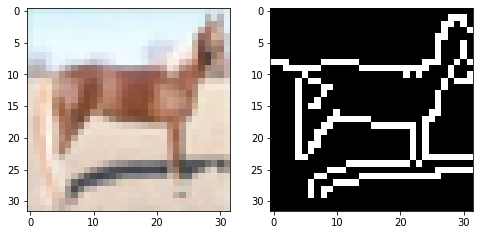

In [28]:
# 画一下图，看看canny轮廓提取效果如何
import cv2
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

original_img = plt.imread(path+'train_data/0/0.bmp')
plt.subplot(1, 2, 1)
plt.imshow(original_img, interpolation='nearest', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
canny_img = cv2.Canny(gray_img, 150, 300)
plt.subplot(1, 2, 2)
plt.imshow(canny_img, interpolation='nearest', cmap='gray')

In [8]:
# source data的变换
source_transform = transforms.Compose([
    # 变成灰度图传入cv2.canny
    transforms.Grayscale(),
    # cv2.Cannay需要np.array传入，但是DataLoader传进来的不是np.array，需要转换
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 150, 300)),
    # 将np.array转换为PILImage进行后面的转换
    transforms.ToPILImage(),
    # data统一转换成64*64，方便之后搭模型
    transforms.Resize(64),
    # 数据增强
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

# target data的变换
target_transform = transforms.Compose([
    # 和target data一样统一变成灰度图
    transforms.Grayscale(),
    # 转换成64*64
    transforms.Resize(64),
    # 数据增强
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

# 直接用ImageFolder读取source_dataset和target_dataset
source_dataset = ImageFolder(path+'train_data/', transform=source_transform)
target_dataset = ImageFolder(path+'testdata_raw/', transform=target_transform)

# load data
source_dataloader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=64, shuffle=True)

## 二、模型搭建和训练

### 1、构建模型
有特征提取器、标签分类器、Domain分类器三个部分。\
FeatrueExtractor采用卷积网络，输入图像来提取特征；\
LabelPredictor采用全连接网络，输入feature extractor得到的feature来判断动物类别；\
DomainClassifier采用全连接网络，输入feature extractor得到的feature来判断feature是来自source data还是target data。

In [9]:
class FeatureExtractor(nn.Module):
    # 卷积网络
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x


class LabelPredictor(nn.Module):
    # 全连接
    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.2),

            nn.Linear(256, 9)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class DomainClassifier(nn.Module):
    # 全连接
    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(512*2*2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### 2、训练模型

In [10]:
# 初始化模型
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

# label predictor用较差熵损失函数
class_criterion = nn.CrossEntropyLoss()
# domain classifier判断是source data还是target data，二分类，用sigmoid+BCE Loss
domain_criterion = nn.BCEWithLogitsLoss()

# 用Adam优化
optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

In [ ]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    # lamb: adversarial layer的loss系数

    # running_D_loss: DomainClassifier的loss
    # running_F_loss: FeatureExtrator 和 LabelPredictor 的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    # correct: 分类正确的个数 
    # total_num: source data总共的个数
    correct, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
        # 提取data
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # source data和target data分布不同，mean和var不同，batch_norm 的时候会出问题
        # 所以要拼接在一起 
        mixed_data = torch.cat([source_data, target_data], dim=0)
        # 设置domain_label，source是1，target是0
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        domain_label[:source_data.shape[0]] = 1

        # 训练Domain Classifier
        feature = feature_extractor(mixed_data)
        # 固定Feature Extractor，不要梯度下降
        domain_logits = domain_classifier(feature.detach())
        # 计算domain classifier的loss
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        # 反向传播，domain classifier希望正确分类，对domain classifier梯度下降
        loss.backward()
        optimizer_D.step()

        # 训练Feature Extractor和Label Predictor
        # source data经过feature extractor后的feature作为input，用label predictor预测label
        class_logits = label_predictor(feature[:source_data.shape[0]])
        # source data经过feature extractor后的feature作为input，用domain classifier预测domain label
        domain_logits = domain_classifier(feature)
        # loss为label predictor的loss - lamb * domain classifier的loss
        # 因为feature extractor希望骗过domain classifier，要最大化其loss，想去相当于梯度上升
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        # FeatureExtrator 和 LabelPredictor 的loss
        running_F_loss+= loss.item()
        # 反向传播
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        # 计算source data中label predictor预测正确的数量
        correct += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]

    # 返回domain classifier的平均loss、feature extracor和lable predictor的平均loss、source data分类正确率
    return running_D_loss / (i+1), running_F_loss / (i+1), correct / total_num

# 训练150个epoch
for epoch in range(150):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1)
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch+1, train_D_loss, train_F_loss, train_acc))

# 保存模型
torch.save(feature_extractor.state_dict(), path+'extractor_model.param')
torch.save(label_predictor.state_dict(), path+'predictor_model.param')

epoch   1: train D loss: 0.5187, train F loss: 2.0285, acc 0.2120
epoch   2: train D loss: 0.6328, train F loss: 1.7164, acc 0.3429
epoch   3: train D loss: 0.6157, train F loss: 1.5185, acc 0.4189
epoch   4: train D loss: 0.5928, train F loss: 1.3860, acc 0.4882
epoch   5: train D loss: 0.5467, train F loss: 1.2896, acc 0.5367
epoch   6: train D loss: 0.5043, train F loss: 1.2594, acc 0.5489
epoch   7: train D loss: 0.5248, train F loss: 1.1928, acc 0.5720
epoch   8: train D loss: 0.4871, train F loss: 1.1607, acc 0.5818
epoch   9: train D loss: 0.4737, train F loss: 1.1493, acc 0.5916
epoch  10: train D loss: 0.4947, train F loss: 1.0781, acc 0.6144
epoch  11: train D loss: 0.4865, train F loss: 1.0585, acc 0.6120
epoch  12: train D loss: 0.4423, train F loss: 1.0367, acc 0.6249
epoch  13: train D loss: 0.4972, train F loss: 0.9775, acc 0.6491
epoch  14: train D loss: 0.4617, train F loss: 0.9577, acc 0.6540
epoch  15: train D loss: 0.4105, train F loss: 0.9050, acc 0.6713
epoch  16:

## 三、预测结果

In [ ]:
# 读取dataset
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)
# 用来储存预测结果
result = []
label_predictor.eval()
feature_extractor.eval()

for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()
    # 用feature extractor + label predictor预测
    class_logits = label_predictor(feature_extractor(test_data))
    # 得到预测结果
    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    # 加入到列表中
    result.append(x)

# 写入CSV保存
result = np.concatenate(result)
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv(path+'res.csv',index=False)

## 四、可视化feature extractor，对比domain adversarial training的效果

为了展现domain adversarial training在训练之后，能够让source data和target data经过feature extracotr的特征分布类似，对比source data和target data在经过不采用domain adversarial training方法得到的feature extractor、和采用domain adversarial training方法得到的feature extractor后，得到的feature分布图



### 1、不采用domain adversarial training的feature分布

首先，训练一个不用domain adversarial training的feature extractor和label predictor，网络结构和采用domain adversarial training的feature extractor和label predictor相同

In [25]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())

class_criterion = nn.CrossEntropyLoss()

def train_epoch_no_dann(source_dataloader):
    # running_D_loss: DomainClassifier的loss
    # running_F_loss: FeatureExtrator 和 LabelPredictor 的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    # correct: 分类正确的个数 
    # total_num: source data总共的个数
    correct, total_num = 0.0, 0.0

    i = 0
    for (source_data, source_label) in source_dataloader:
        # 提取data
        source_data = source_data.cuda()
        source_label = source_label.cuda()

        feature = feature_extractor(source_data)
        # source data经过feature extractor后的feature作为input，用label predictor预测label
        class_logits = label_predictor(feature)
        loss = class_criterion(class_logits, source_label)
        # FeatureExtrator 和 LabelPredictor 的loss
        running_F_loss+= loss.item()
        # 反向传播
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        # 计算source data中label predictor预测正确的数量
        correct += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        i += 1

    # 返回feature extracor和lable predictor的平均loss、source data分类正确率
    return running_F_loss / (i+1), correct / total_num

# 训练150 epochs
for epoch in range(150):
    train_F_loss, train_acc = train_epoch_no_dann(source_dataloader)
    print('epoch {:>3d}: train F loss: {:6.4f}, acc {:6.4f}'.format(epoch+1, train_F_loss, train_acc))
torch.save(feature_extractor.state_dict(), path+'extractor_model_nodann.param')
torch.save(label_predictor.state_dict(), path+'predictor_model_nodann.param')

epoch   1: train F loss: 1.9920, acc 0.2436
epoch   2: train F loss: 1.6724, acc 0.3793
epoch   3: train F loss: 1.4421, acc 0.4900
epoch   4: train F loss: 1.3746, acc 0.5096
epoch   5: train F loss: 1.3159, acc 0.5364
epoch   6: train F loss: 1.2354, acc 0.5727
epoch   7: train F loss: 1.2059, acc 0.5796
epoch   8: train F loss: 1.1653, acc 0.5909
epoch   9: train F loss: 1.1215, acc 0.6076
epoch  10: train F loss: 1.0735, acc 0.6280
epoch  11: train F loss: 1.0468, acc 0.6358
epoch  12: train F loss: 1.0197, acc 0.6469
epoch  13: train F loss: 0.9841, acc 0.6538
epoch  14: train F loss: 0.9709, acc 0.6609
epoch  15: train F loss: 0.9235, acc 0.6787
epoch  16: train F loss: 0.9170, acc 0.6716
epoch  17: train F loss: 0.8613, acc 0.6993
epoch  18: train F loss: 0.8510, acc 0.7080
epoch  19: train F loss: 0.8283, acc 0.7109
epoch  20: train F loss: 0.7782, acc 0.7260
epoch  21: train F loss: 0.7500, acc 0.7316
epoch  22: train F loss: 0.7410, acc 0.7378
epoch  23: train F loss: 0.7347,

然后，对上述不用domain adversarial training得到的模型，看一下source data和target data经过feature extractor得到的feature的分布。先来得到feature。

In [ ]:
feature_extractor = FeatureExtractor().cuda()
feature_extractor.load_state_dict(torch.load(path + 'extractor_model_nodann.param'))
feature_extractor.eval()

source_dataloader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=64, shuffle=True)

for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
    source_data = source_data.cuda()
    target_data = target_data.cuda()

    # 把source data和target data拼接在一起
    mixed_data = torch.cat([source_data, target_data], dim=0)
    # 设置domain_label，source是1，target是0
    domain_label_temp = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
    domain_label_temp[:source_data.shape[0]] = 1
    # 第一次进入循环，建立feature、domain_label直接得到
    if i == 0: 
        feature = feature_extractor(mixed_data)
        domain_label = domain_label_temp.clone()
    # 非第一次进入循环，feature、domain_label与已经得到的feature、domain_label拼接在一起
    else:
        feature = torch.cat([feature, feature_extractor(mixed_data)], dim=0)
        domain_label =  torch.cat([domain_label, domain_label_temp], dim=0)
    # 为了节省时间，做16个batch，大概用了source和target各用了1000个的数据，足以说明问题
    if i == 15:
        break


之后，进行数据降维和可视化。\
根据网络结构，feature extractor输出的feature是2048维，为了可视化，采用TSNE方法降维到2维。可以明显看出，source data和target data得到的feature分布差异很大。

Org data dimension is 2048. Embedded data dimension is 2


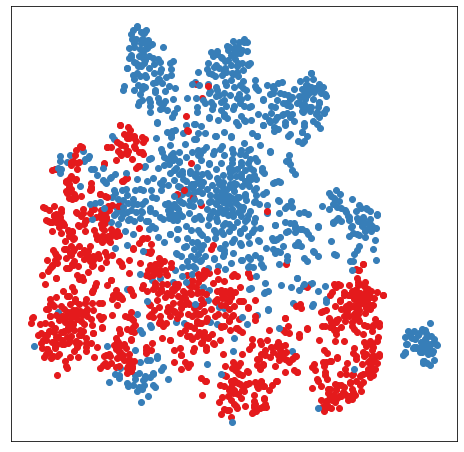

In [12]:
# 将feature进行数据降维，从2048降到2，方便在平面图上进行展示
from sklearn import (manifold, datasets)
X=torch.Tensor.cpu((feature.reshape(feature.shape[0], 512*2*2)) / 255.0).detach()
y=torch.Tensor.cpu(domain_label).detach().numpy()
# 采用TSNE降维的方法，首先运用PCA的方法，然后映射到2维
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
# 对feature进行降维
X_tsne = tsne.fit_transform(X)
 
print("Org data dimension is {}. Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))
 
# 降维后进行可视化

# 归一化
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  
# 画图
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(int(y[i])))
plt.xticks([])
plt.yticks([])
plt.show()


### 2、采用domain adversarial training的feature分布

对之前采用domain adversarial training得到的模型，看一下source data和target data经过feature extractor得到的feature的分布。先来得到feature。

In [ ]:
feature_extractor = FeatureExtractor().cuda()
feature_extractor.load_state_dict(torch.load(path + 'extractor_model.param'))
feature_extractor.eval()

source_dataloader = DataLoader(source_dataset, batch_size=64, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=64, shuffle=True)

for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):
    source_data = source_data.cuda()
    target_data = target_data.cuda()

    # 把source data和target data拼接在一起
    mixed_data = torch.cat([source_data, target_data], dim=0)
    # 设置domain_label，source是1，target是0
    domain_label_temp = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
    domain_label_temp[:source_data.shape[0]] = 1
    # 第一次进入循环，建立feature、domain_label直接得到
    if i == 0: 
        feature = feature_extractor(mixed_data)
        domain_label = domain_label_temp.clone()
    # 非第一次进入循环，feature、domain_label与已经得到的feature、domain_label拼接在一起
    else:
        feature = torch.cat([feature, feature_extractor(mixed_data)], dim=0)
        domain_label =  torch.cat([domain_label, domain_label_temp], dim=0)
    # 为了节省时间，做16个batch，大概用了source和target各用了1000个的数据，足以说明问题
    if i == 15:
        break

之后，进行数据降维和可视化。 \
根据网络结构，feature extractor输出的feature是2048维，为了可视化，采用TSNE方法降维到2维。可以看出，source data和target data得到的feature分布几乎没有差异。

Org data dimension is 2048. Embedded data dimension is 2


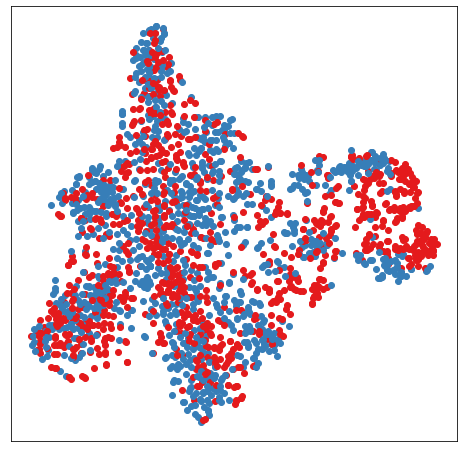

In [22]:
X=torch.Tensor.cpu((feature.reshape(feature.shape[0], 512*2*2)) / 255.0).detach()
y=torch.Tensor.cpu(domain_label).detach().numpy()
# 采用TSNE降维的方法
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
# 对feature进行降维
X_tsne = tsne.fit_transform(X)
 
print("Org data dimension is {}. Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))
 
# 降维后进行可视化

# 归一化
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  
# 画图
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(int(y[i])))
plt.xticks([])
plt.yticks([])
plt.show()
